In [11]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report

import time
from datetime import datetime, timedelta

In [12]:
training_data_imputed_df = pd.read_csv("training_data_imputed_simple_TRAIN.csv.gz") 

In [13]:
training_data_imputed_df.head()
training_data_imputed_df.shape

(90320, 169)

In [14]:
train_df, val_df = train_test_split(training_data_imputed_df, test_size=0.2, random_state=1)

In [15]:
val_df

,ab_class_is_Fluoroquinolone,ab_class_is_Lincosamide,ab_class_is_Nitroimidazole,ab_class_is_Carbapenem,ab_class_is_Aminoglycoside,ab_class_is_Glycopeptide,ab_class_is_Cephalosporin,ab_class_is_Oxazolidinone,ab_class_is_Macrolide,ab_class_is_Lipopeptide,...,count_hematocrit,count_platelets,count_white_blood_cells,age_at_admin,admin_time_since_admission,admission_time_of_day,cdiff_2d_flag,cdiff_7d_flag,cdiff_30d_flag,survival_time
24466,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,6.0,1.0,62.189041,96.0,17.0,0.0,0.0,0.0,9.481944
33121,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,79.339726,0.0,11.0,0.0,0.0,0.0,5.576389
8352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.0,12.0,1.0,77.205479,480.0,22.0,0.0,0.0,0.0,28.506944
58911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,3.0,6.0,1.0,47.356164,0.0,18.0,0.0,0.0,0.0,7.758333
86073,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,55.509589,24.0,23.0,0.0,1.0,1.0,4.541667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7527,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,86.926027,24.0,8.0,0.0,0.0,0.0,5.687500
48785,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,79.038356,0.0,12.0,0.0,0.0,0.0,33.770139
11657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,28.0,30.0,1.0,48.813699,408.0,17.0,0.0,0.0,0.0,18.937500
4207,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,3.0,6.0,1.0,62.813699,240.0,21.0,0.0,0.0,0.0,13.552083


In [16]:
X = train_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y = train_df['cdiff_30d_flag']

print("Class distribution:")
print(y.value_counts())
print(f"Class imbalance ratio: 1:{y.value_counts()[0]/y.value_counts()[1]:.2f}")

Class distribution:
cdiff_30d_flag
0.0    67822
1.0     4434
Name: count, dtype: int64
Class imbalance ratio: 1:15.30


In [17]:
param_grid = {
    'n_estimators': [30, 50, 70],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.1, 0.2, 0.3],
}

xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=0,
    n_jobs=-1
)

scoring = 'roc_auc'

n_splits = 4
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=skf,
    scoring=scoring,
    verbose=1,
    n_jobs=-1  
)

In [18]:
start_time = time.time()
start_datetime = datetime.now()
print(f"Training started at: {start_datetime.strftime('%Y-%m-%d %H:%M:%S')}")

print("Starting GridSearchCV to find optimal parameters...")
grid_search.fit(X, y)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best cross-validation {scoring} score: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

end_time = time.time()
end_datetime = datetime.now()

duration_seconds = end_time - start_time
duration = timedelta(seconds=duration_seconds)

print(f"Training finished at: {end_datetime.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total training time: {duration}")

Training started at: 2025-05-19 16:04:22
Starting GridSearchCV to find optimal parameters...
Fitting 4 folds for each of 27 candidates, totalling 108 fits

Best parameters found:
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 70}
Best cross-validation roc_auc score: 0.8456
Training finished at: 2025-05-19 16:07:32
Total training time: 0:03:10.938760


In [19]:
XGB_model = xgb.XGBClassifier(**grid_search.best_params_, 
                                objective='binary:logistic',
                                eval_metric='auc',
                                random_state=0,
                               n_jobs=-1)
XGB_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.3, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=70,
              n_jobs=-1, num_parallel_tree=None, ...)

In [20]:
X_val = val_df.drop(['cdiff_2d_flag', 'cdiff_7d_flag', 'cdiff_30d_flag', 'survival_time'], axis=1)
y_val = val_df['cdiff_30d_flag']

y_val.value_counts()

cdiff_30d_flag
0.0    17027
1.0     1037
Name: count, dtype: int64

In [21]:
y_val_pred = XGB_model.predict(X_val)
y_val_prob = XGB_model.predict_proba(X_val)[:, 1]  

print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['non-cdiff', 'cdiff']))
print(f"ROC AUC: {roc_auc_score(y_true=y_val, y_score=y_val_pred):.4}")


Classification Report:
              precision    recall  f1-score   support

   non-cdiff       0.95      1.00      0.98     17027
       cdiff       0.91      0.21      0.34      1037

    accuracy                           0.95     18064
   macro avg       0.93      0.60      0.66     18064
weighted avg       0.95      0.95      0.94     18064

ROC AUC: 0.604


<Figure size 1200x800 with 0 Axes>

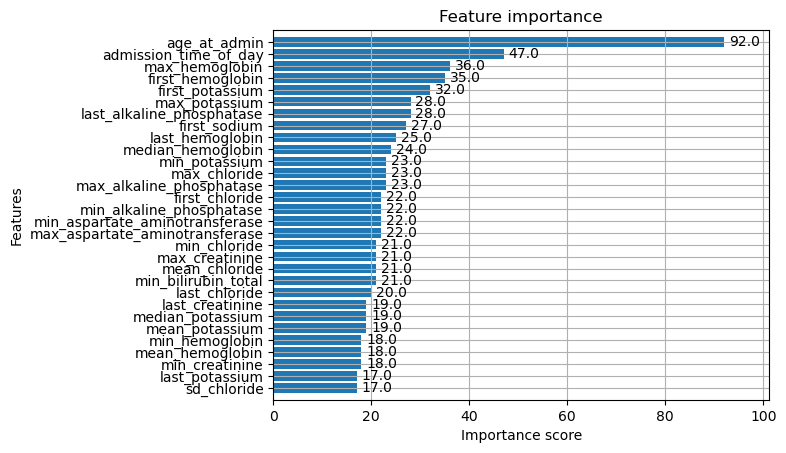

In [22]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(XGB_model, max_num_features=30, height=0.8)
plt.show()

In [23]:
XGB_model.save_model('30d_best_model.json')